In [ ]:
"""
EDM Spectrum Sampling Tool - Demo Script

This script demonstrates how to use the interactive spectrum sampling tool
for generating and visualizing conditional electron spectra.

Usage:
    python spectrum_sampling_demo.py

For Jupyter notebook usage, see the README.md file.
"""

from spectrum_sampling_tool import (
    SpectrumSamplingTool, 
    load_spectrum_tool, 
    quick_sample_and_plot,
    quick_sample_differentiable,
    create_parameter_sweep,
    EXAMPLE_PARAMETER_SETS
)

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from src.utils import deflection_biexp_calc
import pandas as pd

MODEL_PATH = "models/edm_4kepochs/ema_ckpt_final.pt"

def plot_energy_intensity(csv_file):
    """
    Load a CSV file with energy and intensity columns and plot them.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    # Load the CSV file
    data = pd.read_csv(csv_file)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data['energy_MeV'], data['intensity'], linewidth=2)
    
    # Labels and title
    ax.set_xlabel('Energy', fontsize=12)
    ax.set_ylabel('Intensity', fontsize=12)
    ax.set_title('Energy vs Intensity', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

def create_energy_axis(self, electron_pointing_pixel: int = 62) -> np.ndarray:
    """Create energy axis for plotting using biexponential deflection calculation."""
    # Use a larger size to ensure we get enough high-energy values
    temp_size = max(self.spectrum_length * 2, 512)
    
    # Calculate deflection using the biexponential model
    deflection_MeV, _ = deflection_biexp_calc(
        batch_size=1, 
        hor_image_size=temp_size, 
        electron_pointing_pixel=electron_pointing_pixel
    )
    
    # Convert to numpy and take first batch
    deflection_array = deflection_MeV[0].cpu().numpy()
    
    # Remove zeros and get valid energy values
    valid_energies = deflection_array[deflection_array > 0]
    
    # Sort in descending order to get highest energies first
    valid_energies_sorted = np.sort(valid_energies)[::-1]
    
    # Take the top values (highest energies)
    if len(valid_energies_sorted) >= self.spectrum_length:
        energy_axis = valid_energies_sorted[:self.spectrum_length]
    else:
        # If we don't have enough values, pad with zeros
        energy_axis = np.concatenate([
            np.zeros(self.spectrum_length - len(valid_energies_sorted)),
            valid_energies_sorted[::-1]
        ])
    
    return energy_axis

def main():
    # Update this path to your trained model
    
    print("🔬 EDM Spectrum Sampling Tool - Demo")
    print("="*50)
    
    # Check if model exists
    if not Path(MODEL_PATH).exists():
        print(f"❌ Model file not found: {MODEL_PATH}")
        print("Please update MODEL_PATH to point to your trained model.")
        return
    
    print(f"✅ Model found: {MODEL_PATH}")
    print(f"🖥️  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    print()
    
    # Demo 1: Quick sample generation
    print("📊 Demo 1: Quick Sample Generation")
    print("-" * 30)
 
    parameters = { # THis is zero
        "E": 43.871361,    # Laser Energy
        "P": 5.246558,    # Pressure 
        "ms": 64.559244    # Acquisition time (ms)
    }

    # parameters = { 
    #     "E": 13.194736, 
    #     "P": 13.270090, 
    #     "ms": 13.246563
    # }
    
    # parameters = { Low peak, quick drop
    #     "E": 25.0,    # Laser Energy
    #     "P": 15.0,    # Pressure 
    #     "ms": 40.0    # Acquisition time (ms)
    # }

    # parameters = { # peak at 10, weird high energy
    #     "E": 25.0,    # Laser Energy
    #     "P": 15.0,    # Pressure 
    #     "ms": 20.0    # Acquisition time (ms)
    # }

    #parameters = { # Same peak, higher charge
    #    "E": 30.0,    # Laser Energy
    #    "P": 10.0,    # Pressure 
    #    "ms": 20.0    # Acquisition time (ms)
    #}

    # parameters = { # peak at 17, bigger tail
    #    "E": 33.0,    # Laser Energy
    #    "P": 23.0,    # Pressure 
    #    "ms": 40.0    # Acquisition time (ms)
    # }

    # parameters = { # peak at 17
    #     "E": 45.0,    # Laser Energy
    #     "P": 25.0,    # Pressure 
    #     "ms": 20.0    # Acquisition time (ms)
    # }
    
    print(f"Generating spectra with parameters: {parameters}")
    
    try:
        samples, energy_axis = quick_sample_and_plot(
            model_path=MODEL_PATH,
            parameters=parameters,
            n_samples=16,
            device="auto",
            cfg_scale=3.0,
            save_path="avg_spectrum.csv"
        )
        
        print(f"✅ Generated {len(samples)} spectra with shape {samples.shape}")
        print(f"   Energy axis: {len(energy_axis)} points, {energy_axis.min():.2f}-{energy_axis.max():.2f} MeV")
        
    except Exception as e:
        print(f"❌ Error in quick sampling: {e}")
        print("   This might be due to missing dependencies or incorrect model path.")
        return
    
    print("\n" + "="*50)
    print("🎉 Demo completed!")
    print("\nNext steps:")
    print("1. 🚀 Launch interactive tool: Use load_spectrum_tool() in Jupyter")
    print("2. 🔬 Explore parameters: Try different combinations")
    print("3. 📊 Analyze results: Use the batch comparison features")
    print("4. 💾 Export data: Save interesting results for further analysis")
    print("\nFor interactive usage, see the Jupyter notebook examples in the README.")

def interactive_demo():
    """
    Start the interactive tool directly.
    This function can be called from a Jupyter notebook.
    """
    
    print("🚀 Starting Interactive Spectrum Sampling Tool...")
    
    if not Path(MODEL_PATH).exists():
        print(f"❌ Model file not found: {MODEL_PATH}")
        print("Please update MODEL_PATH in the function to point to your trained model.")
        return None
    
    # Load and display the interactive tool
    tool = load_spectrum_tool(
        model_path=MODEL_PATH,
        device="auto",
        spectrum_length=256,
        features=["E", "P", "ms"],
        num_sampling_steps=30
    )
    
    return tool

if __name__ == "__main__":
    interactive_demo() 

In [ ]:
plot_energy_intensity("avg_spectrum_45_25_20.csv")

In [ ]:
import re
from pathlib import Path

def parse_logs(main_folder):
    results = []
    pattern = r'laser_energy=([\d.]+), pressure=([\d.]+), acquisition_time=([\d.]+), MSE=([\d.]+)'
    
    for seed_dir in sorted(Path(main_folder).glob('seed_*')):
        seed_dir_full = Path.joinpath(seed_dir, 'logs')
        for log_file in seed_dir_full.glob('*.log'):
            min_mse = float('inf')
            best_params = None
            
            with open(log_file, 'r') as f:
                for line in f:
                    match = re.search(pattern, line)
                    if match:
                        laser_energy, pressure, acq_time, mse = map(float, match.groups())
                        if mse < min_mse:
                            min_mse = mse
                            best_params = {
                                'seed': seed_dir.name,
                                'laser_energy': laser_energy,
                                'pressure': pressure,
                                'acquisition_time': acq_time,
                                'mse': mse
                            }
            
            if best_params:
                results.append(best_params)
    
    return results

# Usage
results = parse_logs('match_spectrum_20260108_162048/lbfgs')
# print(results)
# Iterate through results
for r in results:
    print(f"{r['seed']}: E={r['laser_energy']:.2f}, P={r['pressure']:.2f}, "
          f"t={r['acquisition_time']:.2f}, MSE={r['mse']:.6f}")

In [ ]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spectrum_sampling_tool import quick_sample_differentiable
from tqdm import tqdm

# ============== Configuration ==============
MODEL_PATH = "models/edm_4kepochs/ema_ckpt_final.pt"
LOGS_FOLDER = "/path/to/your/logs"
TARGET_PARAMS = {"E": 45.0, "P": 25.0, "ms": 20.0}
TARGET_SEED = 42  # Fixed seed for target spectrum reproducibility
N_SAMPLES = 16

# ============== Parse logs ==============
def parse_logs(main_folder):
    results = []
    pattern = r'laser_energy=([\d.]+), pressure=([\d.]+), acquisition_time=([\d.]+), MSE=([\d.]+)'
    
    for seed_dir in sorted(Path(main_folder).glob('seed_*')):
        seed_dir_full = Path.joinpath(seed_dir, 'logs')
        for log_file in seed_dir_full.glob('*.log'):
            min_mse = float('inf')
            best_params = None
            
            with open(log_file, 'r') as f:
                for line in f:
                    match = re.search(pattern, line)
                    if match:
                        laser_energy, pressure, acq_time, mse = map(float, match.groups())
                        if mse < min_mse:
                            min_mse = mse
                            best_params = {
                                'seed': seed_dir.name,
                                'laser_energy': laser_energy,
                                'pressure': pressure,
                                'acquisition_time': acq_time,
                                'mse': mse
                            }
            
            if best_params:
                results.append(best_params)
    
    return results

def extract_seed_number(seed_name):
    """Extract numeric seed from directory name like 'seed_1016' -> 1016"""
    match = re.search(r'seed_(\d+)', seed_name)
    return int(match.group(1)) if match else None

# Usage
seed_results = parse_logs('match_spectrum_20260108_162048/lbfgs')
seed_spectra = []
device = "cuda:1"

print("Generating seed spectra using DifferentiableEdmSampler...")
for r in tqdm(seed_results):
    params = {"E": r['laser_energy'], "P": r['pressure'], "ms": r['acquisition_time']}
    
    # Extract numeric seed from seed directory name for deterministic latents
    seed_num = extract_seed_number(r['seed'])
    
    # Use differentiable sampler with seed for reproducibility
    samples, energy_axis = quick_sample_differentiable(
        model_path=MODEL_PATH,
        parameters=params,
        n_samples=N_SAMPLES,
        device=device,
        cfg_scale=3.0,
        seed=seed_num,  # Use the extracted seed for deterministic latents
        visualize=False,  # Don't show plots during batch generation
        smooth_output=True,
        smooth_sigma=2.0,
        smooth_kernel_size=9
    )
    
    avg_spectrum = samples.mean(axis=0)
    seed_spectra.append({
        'seed': r['seed'],
        'seed_num': seed_num,
        'params': params,
        'mse': r['mse'],
        'spectrum': avg_spectrum,
        'energy_axis': energy_axis
    })
    print(f"  {r['seed']}: E={params['E']:.2f}, P={params['P']:.2f}, ms={params['ms']:.2f}, MSE={r['mse']:.6f}")

# Generate target spectrum with fixed seed for reproducibility
print(f"\nGenerating target spectrum: E={TARGET_PARAMS['E']}, P={TARGET_PARAMS['P']}, ms={TARGET_PARAMS['ms']} (seed={TARGET_SEED})")
target_samples, energy_axis = quick_sample_differentiable(
    model_path=MODEL_PATH,
    parameters=TARGET_PARAMS,
    n_samples=N_SAMPLES,
    device=device,
    cfg_scale=3.0,
    seed=TARGET_SEED,  # Fixed seed for target spectrum
    visualize=False,
    smooth_output=True,
    smooth_sigma=2.0,
    smooth_kernel_size=9
)
target_spectrum = target_samples.mean(axis=0)

# ============== Save data ==============
for s in seed_spectra:
    df = pd.DataFrame({'energy_MeV': s['energy_axis'], 'intensity': s['spectrum']})
    df.to_csv(f"spectrum_{s['seed']}.csv", index=False)

df_target = pd.DataFrame({'energy_MeV': energy_axis, 'intensity': target_spectrum})
df_target.to_csv("spectrum_target_45_25_20.csv", index=False)

print(f"\nSaved {len(seed_spectra) + 1} spectra to CSV files")

# ============== Plot ==============
fig, ax = plt.subplots(figsize=(10, 6))

# Stack all seed spectra and compute mean and std
all_spectra = np.stack([s['spectrum'] for s in seed_spectra], axis=0)
mean_spectrum = np.mean(all_spectra, axis=0)
std_spectrum = np.std(all_spectra, axis=0)

# Plot uncertainty band (std) in greyed red
ax.fill_between(energy_axis, mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, 
                color='red', alpha=0.2, label='_nolegend_')

# Plot mean spectrum in red
ax.plot(energy_axis, mean_spectrum, 'r-', linewidth=2)

# Plot target spectrum in blue
ax.plot(energy_axis, target_spectrum, 'b-', linewidth=2)
ax.set_xlim(0, 50)

ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('Seed Optimization Results vs Target Spectrum')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
custom_lines = [Line2D([0], [0], color='r', linestyle='-', linewidth=2),
                Patch(facecolor='red', alpha=0.2, edgecolor='red'),
                Line2D([0], [0], color='b', linestyle='-', linewidth=2)]
ax.legend(custom_lines, [f'Mean (n={len(seed_spectra)} seeds)', 'Std deviation', 'Target (45, 25, 20)'])

plt.tight_layout()
plt.savefig('seed_vs_target_spectra.png', dpi=150)
plt.show()

print("\n✅ Plot saved to seed_vs_target_spectra.png")

In [ ]:
# ============== Load saved CSVs and plot with MEDIAN ==============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Load target spectrum
target_df = pd.read_csv("spectrum_target_45_25_20.csv")
target_spectrum = target_df['intensity'].values
energy_axis = target_df['energy_MeV'].values

# Load all seed spectra from CSV files
seed_csv_files = sorted(Path('.').glob('spectrum_seed_*.csv'))
print(f"Found {len(seed_csv_files)} seed spectrum CSV files")

all_spectra = []
for csv_file in seed_csv_files:
    df = pd.read_csv(csv_file)
    all_spectra.append(df['intensity'].values)
    print(f"  Loaded: {csv_file.name}")

all_spectra = np.stack(all_spectra, axis=0)
print(f"\nLoaded spectra shape: {all_spectra.shape}")

# Compute median and interquartile range (IQR)
median_spectrum = np.median(all_spectra, axis=0)
q25 = np.percentile(all_spectra, 25, axis=0)
q75 = np.percentile(all_spectra, 75, axis=0)

# ============== Plot ==============
fig, ax = plt.subplots(figsize=(10, 6))

# Plot uncertainty band (IQR: 25th-75th percentile) in greyed red
# ax.fill_between(energy_axis, q25, q75, 
#                color='red', alpha=0.2, label='_nolegend_')

# Plot median spectrum in red
ax.plot(energy_axis, median_spectrum, 'r-', linewidth=2)

# Plot target spectrum in blue
ax.plot(energy_axis, target_spectrum, 'b-', linewidth=2)
ax.set_xlim(0, 50)

ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('Seed Optimization Results vs Target Spectrum (Median)')

custom_lines = [Line2D([0], [0], color='r', linestyle='-', linewidth=2),
                Patch(facecolor='red', alpha=0.2, edgecolor='red'),
                Line2D([0], [0], color='b', linestyle='-', linewidth=2)]
ax.legend(custom_lines, [f'Median (n={len(seed_csv_files)} seeds)', 'IQR (25th-75th percentile)', 'Target (45, 25, 20)'])

plt.tight_layout()
plt.savefig('seed_vs_target_spectra_median.png', dpi=150)
plt.show()

print("\n✅ Plot saved to seed_vs_target_spectra_median.png")


In [1]:
# ============== STEP 1: Generate and save all spectra ==============
import json
import numpy as np
import pandas as pd
from pathlib import Path
from spectrum_sampling_tool import quick_sample_differentiable
from tqdm import tqdm

# Configuration
COMPARISON_FOLDER = "comparison_20260114_110450"
MODEL_PATH = "models/edm_4kepochs/ema_ckpt_final.pt"
DEVICE = "cuda:1"
N_SAMPLES = 16

# Create output folder for generated spectra
SPECTRA_OUTPUT_FOLDER = f"{COMPARISON_FOLDER}/generated_spectra"
Path(SPECTRA_OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

# Load results.json
results_path = f"{COMPARISON_FOLDER}/results.json"
with open(results_path, 'r') as f:
    results = json.load(f)

# Load config to get target spectrum info
config_path = f"{COMPARISON_FOLDER}/config.json"
with open(config_path, 'r') as f:
    config = json.load(f)

# Load target spectrum
target_csv = config['opt_params']['target_spectrum_csv']
target_df = pd.read_csv(target_csv)
target_spectrum = target_df['intensity'].values
energy_axis = target_df['energy_MeV'].values

# Save target spectrum to the output folder
target_output_path = f"{SPECTRA_OUTPUT_FOLDER}/target_spectrum.csv"
target_df.to_csv(target_output_path, index=False)

print(f"Loaded target spectrum from: {target_csv}")
print(f"Saved target spectrum to: {target_output_path}")
print(f"Number of approaches: {len(results)}")
print(f"Approaches: {list(results.keys())}")
print(f"\nGenerating spectra for all approaches and seeds...")
print("=" * 80)

# For each approach, generate and save spectra
total_count = 0
for approach_name, approach_results in results.items():
    print(f"\nProcessing approach: {approach_name}")
    print(f"  Number of seeds: {len(approach_results)}")
    
    # Create folder for this approach
    approach_folder = Path(SPECTRA_OUTPUT_FOLDER) / approach_name
    approach_folder.mkdir(parents=True, exist_ok=True)
    
    for seed_id, seed_data in tqdm(approach_results.items(), desc=f"  {approach_name}"):
        # Get best parameters
        best_params = seed_data['best_params']
        params = {
            "E": best_params[0],      # Laser Energy
            "P": best_params[1],      # Pressure
            "ms": best_params[2]      # Acquisition time
        }
        
        # Use the actual seed number from the run
        seed_num = int(seed_id)
        
        # Generate spectrum with these parameters using the correct seed
        samples, spectrum_energy_axis = quick_sample_differentiable(
            model_path=MODEL_PATH,
            parameters=params,
            n_samples=N_SAMPLES,
            device=DEVICE,
            cfg_scale=3.0,
            seed=seed_num,  # Use the actual seed from the folder name
            visualize=False,
            smooth_output=True,
            smooth_sigma=2.0,
            smooth_kernel_size=9
        )
        
        # Average across samples to get the spectrum for this seed
        avg_spectrum = samples.mean(axis=0)
        
        # Save spectrum to CSV
        spectrum_df = pd.DataFrame({
            'energy_MeV': spectrum_energy_axis,
            'intensity': avg_spectrum
        })
        output_path = approach_folder / f"seed_{seed_id}.csv"
        spectrum_df.to_csv(output_path, index=False)
        total_count += 1

print("\n" + "=" * 80)
print(f"✅ Generation complete!")
print(f"   Total spectra generated: {total_count}")
print(f"   Output folder: {SPECTRA_OUTPUT_FOLDER}")
print(f"   Structure: {SPECTRA_OUTPUT_FOLDER}/[approach]/seed_[number].csv")


Loaded target spectrum from: avg_spectrum_45_25_20.csv
Saved target spectrum to: comparison_20260114_110450/generated_spectra/target_spectrum.csv
Number of approaches: 9
Approaches: ['bayesian_only', 'adam_only', 'lbfgs_only', 'bayes_adam', 'bayes_lbfgs', 'adam_lbfgs', 'bayes_adam_lbfgs', 'bayes_lbfgs_adam', 'bayes_sgd']

Generating spectra for all approaches and seeds...

Processing approach: bayesian_only
  Number of seeds: 10


  bayesian_only:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=67


  bayesian_only:  10%|█         | 1/10 [00:03<00:31,  3.46s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=156


  bayesian_only:  20%|██        | 2/10 [00:04<00:17,  2.22s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=236


  bayesian_only:  30%|███       | 3/10 [00:06<00:12,  1.83s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=391


  bayesian_only:  40%|████      | 4/10 [00:07<00:10,  1.70s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=429


  bayesian_only:  50%|█████     | 5/10 [00:09<00:07,  1.57s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=504


  bayesian_only:  60%|██████    | 6/10 [00:10<00:06,  1.51s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=742


  bayesian_only:  70%|███████   | 7/10 [00:12<00:05,  1.69s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=782


  bayesian_only:  80%|████████  | 8/10 [00:13<00:03,  1.58s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=823


  bayesian_only:  90%|█████████ | 9/10 [00:15<00:01,  1.50s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=918


  bayesian_only: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]



Processing approach: adam_only
  Number of seeds: 10


  adam_only:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=67


  adam_only:  10%|█         | 1/10 [00:02<00:18,  2.08s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=156


  adam_only:  20%|██        | 2/10 [00:03<00:13,  1.64s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=236


  adam_only:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=391


  adam_only:  40%|████      | 4/10 [00:06<00:08,  1.45s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=429


  adam_only:  50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=504


  adam_only:  60%|██████    | 6/10 [00:09<00:06,  1.65s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=742


  adam_only:  70%|███████   | 7/10 [00:11<00:04,  1.55s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=782


  adam_only:  80%|████████  | 8/10 [00:12<00:02,  1.48s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=823


  adam_only:  90%|█████████ | 9/10 [00:14<00:01,  1.71s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=918


  adam_only: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]



Processing approach: lbfgs_only
  Number of seeds: 10


  lbfgs_only:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=67


  lbfgs_only:  10%|█         | 1/10 [00:01<00:12,  1.34s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=156


  lbfgs_only:  20%|██        | 2/10 [00:02<00:11,  1.49s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=236


  lbfgs_only:  30%|███       | 3/10 [00:04<00:12,  1.75s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=391


  lbfgs_only:  40%|████      | 4/10 [00:06<00:09,  1.61s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=429


  lbfgs_only:  50%|█████     | 5/10 [00:07<00:07,  1.52s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=504


  lbfgs_only:  60%|██████    | 6/10 [00:09<00:05,  1.46s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=742


  lbfgs_only:  70%|███████   | 7/10 [00:11<00:05,  1.69s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=782


  lbfgs_only:  80%|████████  | 8/10 [00:12<00:03,  1.64s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=823


  lbfgs_only:  90%|█████████ | 9/10 [00:14<00:01,  1.56s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=918


  lbfgs_only: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]



Processing approach: bayes_adam
  Number of seeds: 10


  bayes_adam:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=67


  bayes_adam:  10%|█         | 1/10 [00:02<00:19,  2.14s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=156


  bayes_adam:  20%|██        | 2/10 [00:03<00:13,  1.67s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=236


  bayes_adam:  30%|███       | 3/10 [00:04<00:10,  1.52s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=391


  bayes_adam:  40%|████      | 4/10 [00:06<00:08,  1.45s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=429


  bayes_adam:  50%|█████     | 5/10 [00:08<00:08,  1.73s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=504


  bayes_adam:  60%|██████    | 6/10 [00:09<00:06,  1.60s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=742


  bayes_adam:  70%|███████   | 7/10 [00:11<00:04,  1.53s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=782


  bayes_adam:  80%|████████  | 8/10 [00:12<00:02,  1.47s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=823


  bayes_adam:  90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=918


  bayes_adam: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]



Processing approach: bayes_lbfgs
  Number of seeds: 10


  bayes_lbfgs:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=67


  bayes_lbfgs:  10%|█         | 1/10 [00:01<00:12,  1.33s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=156


  bayes_lbfgs:  20%|██        | 2/10 [00:02<00:11,  1.46s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=236


  bayes_lbfgs:  30%|███       | 3/10 [00:04<00:12,  1.73s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=391


  bayes_lbfgs:  40%|████      | 4/10 [00:06<00:09,  1.60s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=429


  bayes_lbfgs:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=504


  bayes_lbfgs:  60%|██████    | 6/10 [00:09<00:05,  1.46s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=742


  bayes_lbfgs:  70%|███████   | 7/10 [00:11<00:05,  1.70s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=782


  bayes_lbfgs:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=823


  bayes_lbfgs:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=918


  bayes_lbfgs: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]



Processing approach: adam_lbfgs
  Number of seeds: 10


  adam_lbfgs:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=67


  adam_lbfgs:  10%|█         | 1/10 [00:02<00:18,  2.03s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=156


  adam_lbfgs:  20%|██        | 2/10 [00:03<00:13,  1.64s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=236


  adam_lbfgs:  30%|███       | 3/10 [00:04<00:10,  1.51s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=391


  adam_lbfgs:  40%|████      | 4/10 [00:06<00:08,  1.44s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=429


  adam_lbfgs:  50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=504


  adam_lbfgs:  60%|██████    | 6/10 [00:09<00:06,  1.57s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=742


  adam_lbfgs:  70%|███████   | 7/10 [00:11<00:04,  1.56s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=782


  adam_lbfgs:  80%|████████  | 8/10 [00:12<00:02,  1.49s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=823


  adam_lbfgs:  90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=918


  adam_lbfgs: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]



Processing approach: bayes_adam_lbfgs
  Number of seeds: 10


  bayes_adam_lbfgs:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=67


  bayes_adam_lbfgs:  10%|█         | 1/10 [00:01<00:12,  1.34s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=156


  bayes_adam_lbfgs:  20%|██        | 2/10 [00:02<00:10,  1.34s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=236


  bayes_adam_lbfgs:  30%|███       | 3/10 [00:05<00:12,  1.79s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=391


  bayes_adam_lbfgs:  40%|████      | 4/10 [00:06<00:09,  1.61s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=429


  bayes_adam_lbfgs:  50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=504


  bayes_adam_lbfgs:  60%|██████    | 6/10 [00:09<00:06,  1.51s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=742


  bayes_adam_lbfgs:  70%|███████   | 7/10 [00:11<00:05,  1.69s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=782


  bayes_adam_lbfgs:  80%|████████  | 8/10 [00:12<00:03,  1.58s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=823


  bayes_adam_lbfgs:  90%|█████████ | 9/10 [00:14<00:01,  1.51s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=918


  bayes_adam_lbfgs: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]



Processing approach: bayes_lbfgs_adam
  Number of seeds: 10


  bayes_lbfgs_adam:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=67


  bayes_lbfgs_adam:  10%|█         | 1/10 [00:02<00:19,  2.18s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=156


  bayes_lbfgs_adam:  20%|██        | 2/10 [00:03<00:13,  1.69s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=236


  bayes_lbfgs_adam:  30%|███       | 3/10 [00:04<00:10,  1.55s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=391


  bayes_lbfgs_adam:  40%|████      | 4/10 [00:06<00:09,  1.59s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=429


  bayes_lbfgs_adam:  50%|█████     | 5/10 [00:08<00:08,  1.74s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=504


  bayes_lbfgs_adam:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=742


  bayes_lbfgs_adam:  70%|███████   | 7/10 [00:11<00:04,  1.53s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=782


  bayes_lbfgs_adam:  80%|████████  | 8/10 [00:12<00:02,  1.50s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=823


  bayes_lbfgs_adam:  90%|█████████ | 9/10 [00:14<00:01,  1.68s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=918


  bayes_lbfgs_adam: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]



Processing approach: bayes_sgd
  Number of seeds: 10


  bayes_sgd:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=67


  bayes_sgd:  10%|█         | 1/10 [00:01<00:12,  1.41s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=156


  bayes_sgd:  20%|██        | 2/10 [00:02<00:11,  1.41s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=236


  bayes_sgd:  30%|███       | 3/10 [00:04<00:11,  1.70s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=391


  bayes_sgd:  40%|████      | 4/10 [00:06<00:09,  1.56s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=429


  bayes_sgd:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=504


  bayes_sgd:  60%|██████    | 6/10 [00:08<00:05,  1.44s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=742


  bayes_sgd:  70%|███████   | 7/10 [00:11<00:05,  1.70s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=782


  bayes_sgd:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=823


  bayes_sgd:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

Initializing Spectrum Sampling Tool...
Device: cuda:1
Spectrum length: 256
Features: ['E', 'P', 'ms']
Sampling steps: 30
✅ Model loaded from: models/edm_4kepochs/ema_ckpt_final.pt
✅ Initialization complete!
Initialized deterministic latents with shape (16, 1, 256) on cuda:1
✅ Differentiable sampler initialized with 16 samples, seed=918


  bayes_sgd: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


✅ Generation complete!
   Total spectra generated: 90
   Output folder: comparison_20260114_110450/generated_spectra
   Structure: comparison_20260114_110450/generated_spectra/[approach]/seed_[number].csv


Loading spectra from: comparison_20260114_110450/generated_spectra
  adam_lbfgs: loaded 10 seeds, mean computed
  adam_only: loaded 10 seeds, mean computed
  bayes_adam: loaded 10 seeds, mean computed
  bayes_adam_lbfgs: loaded 10 seeds, mean computed
  bayes_lbfgs: loaded 10 seeds, mean computed
  bayes_lbfgs_adam: loaded 10 seeds, mean computed
  bayes_sgd: loaded 10 seeds, mean computed
  bayesian_only: loaded 10 seeds, mean computed
  lbfgs_only: loaded 10 seeds, mean computed

Total approaches loaded: 9


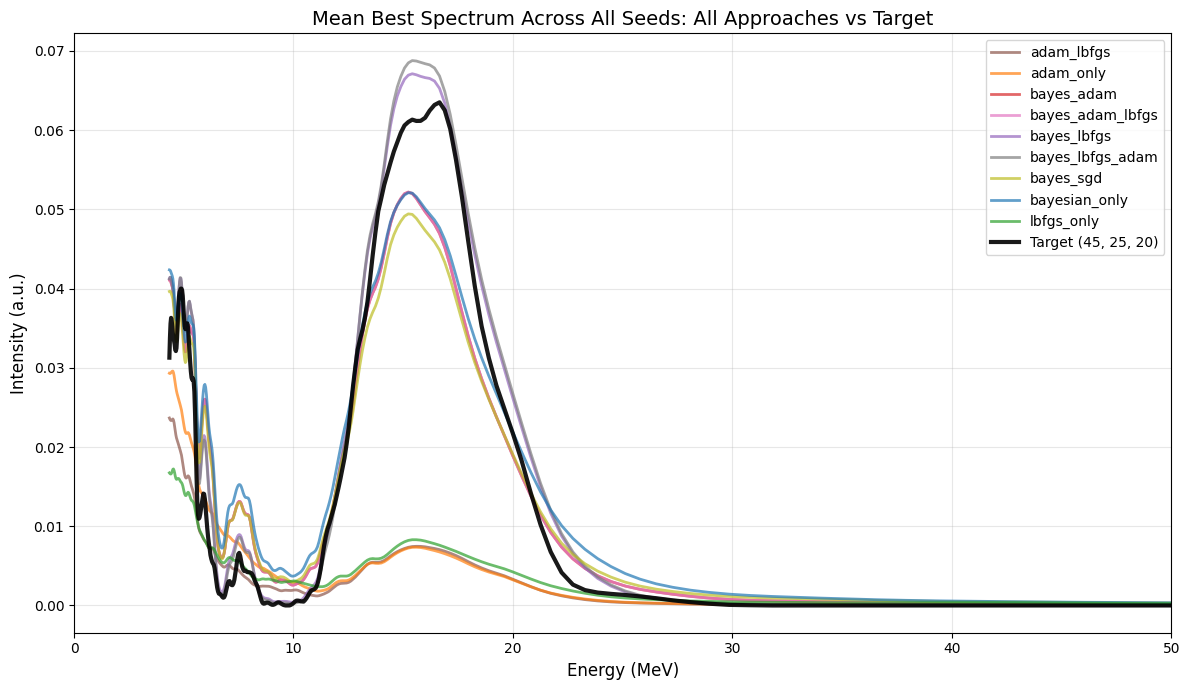


✅ Plot saved to: comparison_20260114_110450/mean_spectra_comparison.png


In [3]:
# ============== STEP 2: Load saved spectra and create plot ==============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
COMPARISON_FOLDER = "comparison_20260114_110450"
SPECTRA_OUTPUT_FOLDER = f"{COMPARISON_FOLDER}/generated_spectra"

# Load target spectrum
target_path = f"{SPECTRA_OUTPUT_FOLDER}/target_spectrum.csv"
target_df = pd.read_csv(target_path)
target_spectrum = target_df['intensity'].values
energy_axis = target_df['energy_MeV'].values

print(f"Loading spectra from: {SPECTRA_OUTPUT_FOLDER}")
print("=" * 80)

# Load all approach folders
approach_folders = sorted([d for d in Path(SPECTRA_OUTPUT_FOLDER).iterdir() if d.is_dir()])

# Collect mean spectra for each approach
approach_mean_spectra = {}

for approach_folder in approach_folders:
    approach_name = approach_folder.name
    
    # Load all seed spectra for this approach
    seed_files = sorted(approach_folder.glob("seed_*.csv"))
    approach_spectra = []
    
    for seed_file in seed_files:
        df = pd.read_csv(seed_file)
        approach_spectra.append(df['intensity'].values)
    
    # Compute mean across all seeds
    all_spectra = np.stack(approach_spectra, axis=0)
    mean_spectrum = np.mean(all_spectra, axis=0)
    
    approach_mean_spectra[approach_name] = mean_spectrum
    print(f"  {approach_name}: loaded {len(seed_files)} seeds, mean computed")

print("\n" + "=" * 80)
print(f"Total approaches loaded: {len(approach_mean_spectra)}")

# ============== Plot all approaches vs target ==============
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors for different approaches
colors = {
    'bayesian_only': '#1f77b4',
    'adam_only': '#ff7f0e',
    'lbfgs_only': '#2ca02c',
    'bayes_adam': '#d62728',
    'bayes_lbfgs': '#9467bd',
    'adam_lbfgs': '#8c564b',
    'bayes_adam_lbfgs': '#e377c2',
    'bayes_lbfgs_adam': '#7f7f7f',
    'bayes_sgd': '#bcbd22'
}

# Plot each approach
for approach_name, mean_spectrum in approach_mean_spectra.items():
    color = colors.get(approach_name, None)
    ax.plot(energy_axis, mean_spectrum, linewidth=2, label=approach_name, color=color, alpha=0.7)

# Plot target spectrum in bold black
ax.plot(energy_axis, target_spectrum, 'k-', linewidth=3, label='Target (45, 25, 20)', alpha=0.9)

ax.set_xlim(0, 50)
ax.set_xlabel('Energy (MeV)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)
ax.set_title('Mean Best Spectrum Across All Seeds: All Approaches vs Target', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_path = f"{COMPARISON_FOLDER}/mean_spectra_comparison.png"
plt.savefig(save_path, dpi=150)
plt.show()

print(f"\n✅ Plot saved to: {save_path}")


Loading spectra for approach: bayes_lbfgs_adam
Number of seeds: 10
  Loaded: seed_156.csv
  Loaded: seed_236.csv
  Loaded: seed_391.csv
  Loaded: seed_429.csv
  Loaded: seed_504.csv
  Loaded: seed_67.csv
  Loaded: seed_742.csv
  Loaded: seed_782.csv
  Loaded: seed_823.csv
  Loaded: seed_918.csv

Mean spectrum computed (shape: (256,))


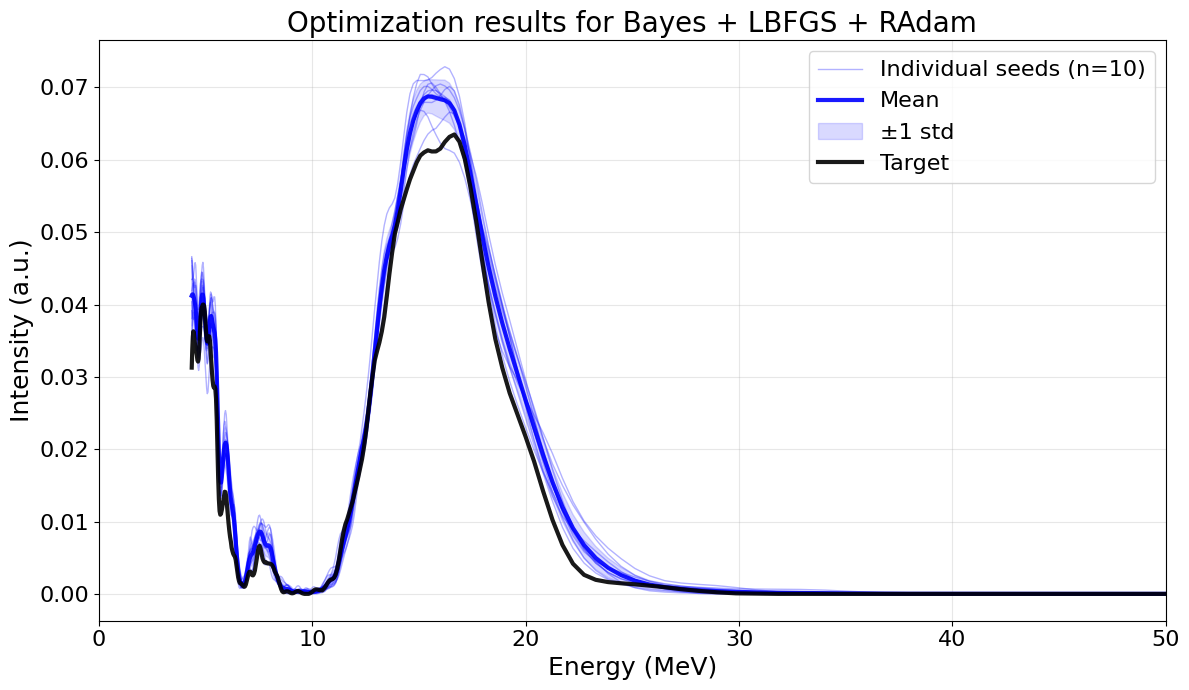


✅ Plot saved to: comparison_20260114_110450/individual_seeds_bayes_lbfgs_adam.png


In [1]:
# ============== STEP 3: Plot all individual seed spectra for one approach ==============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
COMPARISON_FOLDER = "comparison_20260114_110450"
SPECTRA_OUTPUT_FOLDER = f"{COMPARISON_FOLDER}/generated_spectra"

# ========== SELECT APPROACH HERE ==========
SELECTED_APPROACH = "bayes_lbfgs_adam"  # Change this to any approach you want to visualize
# Options: bayesian_only, adam_only, lbfgs_only, bayes_adam, bayes_lbfgs, 
#          adam_lbfgs, bayes_adam_lbfgs, bayes_lbfgs_adam, bayes_sgd
# ===========================================

# Load target spectrum
target_path = f"{SPECTRA_OUTPUT_FOLDER}/target_spectrum.csv"
target_df = pd.read_csv(target_path)
target_spectrum = target_df['intensity'].values
energy_axis = target_df['energy_MeV'].values

# Load all seed spectra for the selected approach
approach_folder = Path(SPECTRA_OUTPUT_FOLDER) / SELECTED_APPROACH
seed_files = sorted(approach_folder.glob("seed_*.csv"))

print(f"Loading spectra for approach: {SELECTED_APPROACH}")
print(f"Number of seeds: {len(seed_files)}")
print("=" * 80)

# Load all individual spectra
individual_spectra = []
seed_names = []

for seed_file in seed_files:
    df = pd.read_csv(seed_file)
    individual_spectra.append(df['intensity'].values)
    # Extract seed number from filename
    seed_name = seed_file.stem.replace("seed_", "")
    seed_names.append(seed_name)
    print(f"  Loaded: {seed_file.name}")

# Compute mean spectrum
all_spectra = np.stack(individual_spectra, axis=0)
mean_spectrum = np.mean(all_spectra, axis=0)
std_spectrum = np.std(all_spectra, axis=0)

print(f"\nMean spectrum computed (shape: {mean_spectrum.shape})")

# ============== Plot ==============
fig, ax = plt.subplots(figsize=(12, 7))

# Plot all individual seed spectra with transparency
for i, (spectrum, seed_name) in enumerate(zip(individual_spectra, seed_names)):
    ax.plot(energy_axis, spectrum, linewidth=1, alpha=0.3, color='blue', label='_nolegend_' if i > 0 else f'Individual seeds (n={len(seed_names)})')

# Plot mean spectrum in bold blue
ax.plot(energy_axis, mean_spectrum, 'b-', linewidth=3, label='Mean', alpha=0.9)

# Plot std as shaded region
ax.fill_between(energy_axis, mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, 
                color='blue', alpha=0.15, label='±1 std')

# Plot target spectrum in bold black
ax.plot(energy_axis, target_spectrum, 'k-', linewidth=3, label='Target', alpha=0.9)

ax.set_xlim(0, 50)
ax.set_xlabel('Energy (MeV)', fontsize=18)
ax.set_ylabel('Intensity (a.u.)', fontsize=18)
ax.set_title('Optimization results for Bayes + LBFGS + RAdam', fontsize=20)
ax.legend(loc='best', fontsize=16)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
save_path = f"{COMPARISON_FOLDER}/individual_seeds_{SELECTED_APPROACH}.png"
plt.savefig(save_path, dpi=150)
plt.show()

print(f"\n✅ Plot saved to: {save_path}")
